# **«Анализ эмбеддингов в CLIP»**

  

### **Мини паспорт эксперимента**

**Данные:** CIFAR10 (5 классов × ≤ 50 изображений/класс)

**Эпохи/шаги:** 100 эпох

**Batch:** 256 (если нет — memory bank)

**LR:** 1e-3 (Adam), τ (температура) = 0.5

**Аугментации:** crop/flip/gaussian noise/jitter


**Прочее:** проекция MLP: 2 слоя по 128–256

**Готово, если:** Linear evaluation на эмбеддингах ≥ 90% (MNIST) и выше модели без контрастивного обучения; есть t SNE/UMAP 2D карты.

---
  
**Цель:** Исследовать расположение текстовых и визуальных признаков в общем пространстве.

**Описание:** Предобученный CLIP (ViT‑B/32) на наборе из 10–20 изображений и коротких подписей.

**Ход работы:** 
- Посчитать эмбеддинги изображений и текстов; косинусное сходство. 
- Выполнить снижение размерности (t‑SNE/UMAP) и визуализацию. 
- (Опционально) Малый декодер‑MLP для восстановления текста из эмбеддинга.

**Результат:** Графики кластеризации и таблица совпадений «картинка–подпись».

**Подсказки:** Для CPU использовать ViT‑B/32; ограничить набор 5 классов × 50 изображений.

Вариант с нелинейными эмбеддингами (декодер из картинки в текстовое пространство).
CLIP используете только как замороженный извлекатель признаков изображения; сверху обучаете небольшой нелинейный декодер, который по image-features предсказывает векторы в текстовом пространстве CLIP. Суть — восстановить «текстовую мысль» из визуального представления и посмотреть, где эти предсказанные тексты поселяются: совпадают ли они с истинными text-features, насколько сдвигаются относительно реальных подписей, и можно ли по ним делать осмысленный zero-shot matching. Если удаётся стабильно получать близкие к текстовым вектора, это прямое указание на нелинейную, но воспроизводимую связь между модальностями; если нет — фиксируете, в чём именно расхождение (например, линейный декодер слаб, а небольшой MLP уже тянет), и делаете вывод про ранг и кривизну соответствия. Этот вариант чуть сложнее, зато даёт содержательный результат про геометрию общего пространства, а не только про локальную подгонку.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import clip
from PIL import Image
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

python3.12 -m venv env

pip install -r lib.txt

In [11]:
MODEL_NAME = "ViT-B/32"
SEED = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCH = 100
BATCH_SIZE = 32

In [ ]:
IMAGE_TRAIN = "data/train" 
IMAGE_TEST = "data/test"
CLASSES = ['cat', 'deer', 'airplane', 'automobile', 'bird']
MAX_IMAGES = 20

In [13]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [14]:
model, preprocess = clip.load(MODEL_NAME, device=DEVICE)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [15]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 151,277,313


In [16]:
def get_embeddings(folder, cls_name = CLASSES):
    image_features, text_features = [], []
    labels = []
    
    with torch.no_grad():
        # text embendings
        for cls in cls_name:
            cls_dir = os.path.join(folder, cls)
            text_token = clip.tokenize([f"a photo of a {cls}"])
            text_feat = model.encode_text(text_token)
            
            text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
            # image embendings
            for img_name in os.listdir(cls_dir):
                img_dir = os.path.join(cls_dir, img_name)
                img = preprocess(Image.open(img_dir)).unsqueeze(0).to(DEVICE)
                img_feat = model.encode_image(img)

                img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

                image_features.append(img_feat)
                text_features.append(text_feat)

                labels.append(cls)
    return torch.cat(image_features), torch.cat(text_features), labels


In [17]:
features_img_train, features_txt_train, labels_train = get_embeddings(IMAGE_TRAIN, CLASSES)
features_img_test, features_txt_test, labels_test = get_embeddings(IMAGE_TEST, CLASSES)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dat\\train\\cat'

In [ ]:
print(f"features_img_train: {len(features_img_train)}")
print(f"features_txt_train: {len(features_txt_train)}")
print(f"labels_train: {len(labels_train)}")
print("-------------------")
print(f"features_img_test: {len(features_img_test)}")
print(f"features_txt_test: {len(features_txt_test)}")
print(f"labels_test: {len(labels_test)}")

features_img_train: 100
features_txt_train: 100
labels_train: 100

------------------

features_img_test: 250
features_txt_test: 250
labels_test: 250


In [ ]:
print(f"Data shape: {features_img_train.shape}")

Data shape: torch.Size([100, 512])


In [ ]:
for i, cls in enumerate(CLASSES):
    txt = features_txt_train[i]
    imgs = features_img_train[np.array(labels_train) == cls]
    sims = imgs @ txt
    print(cls, sims.mean())

cat tensor(0.2573)
deer tensor(0.2177)
airplane tensor(0.2009)
automobile tensor(0.1959)
bird tensor(0.2227)


C:\Users\root\AppData\Local\Temp\ipykernel_9988\3827630292.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


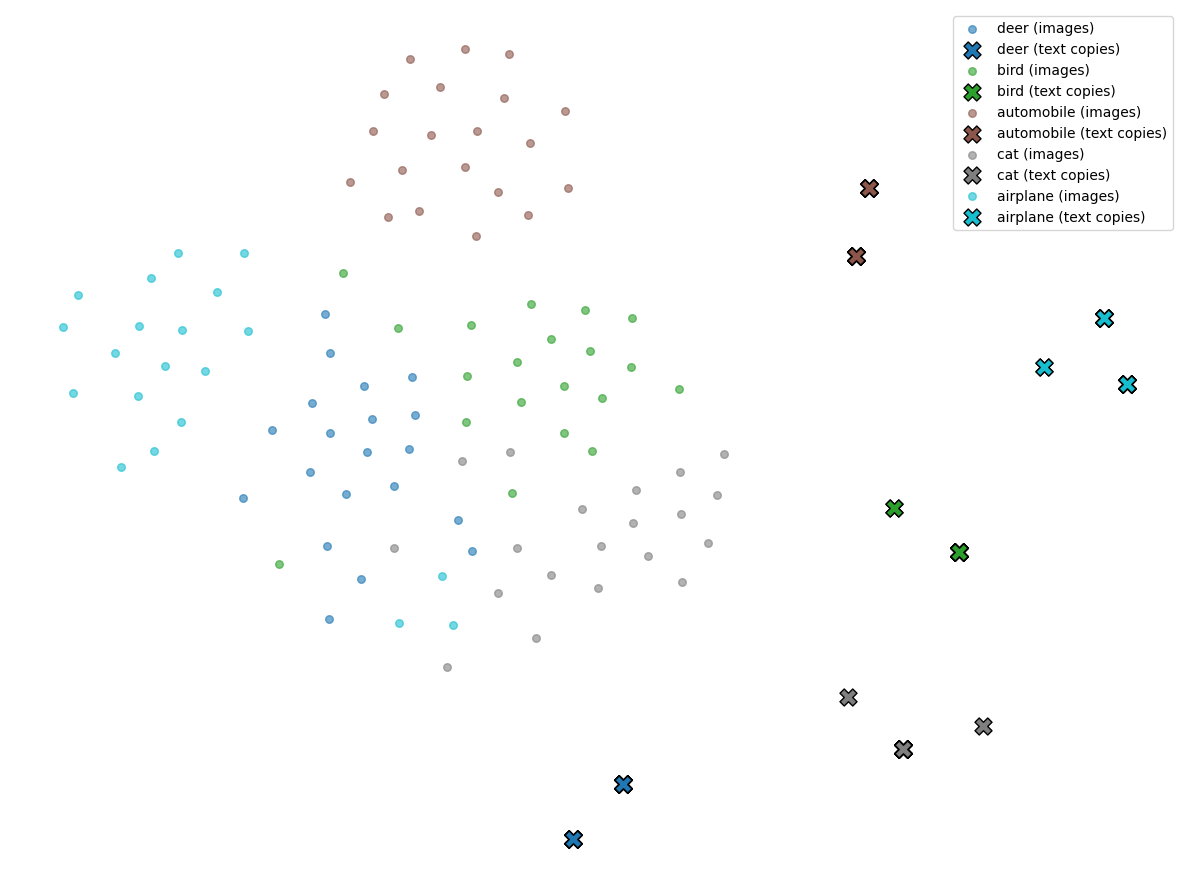

In [ ]:
img_embs = features_img_train.cpu().numpy()
txt_embs = features_txt_train.cpu().numpy()

all_embs = np.vstack([txt_embs, img_embs])

# t-SNE
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
tsne = TSNE(n_components=2, perplexity=30, n_iter_without_progress=300, random_state=SEED)
all_2d = tsne.fit_transform(all_embs)

txt_2d = all_2d[:len(txt_embs)]
img_2d = all_2d[len(txt_embs):]

labels_np = np.array(labels_train)
unique_classes = list(set(labels_train))
colors = plt.cm.get_cmap('tab10', len(unique_classes))

plt.figure(figsize=(12, 9))

for i, cls in enumerate(unique_classes):
    img_mask = (labels_np == cls)

    # img
    plt.scatter(
        img_2d[img_mask, 0],
        img_2d[img_mask, 1],
        c=[colors(i)],
        label=f'{cls} (images)',
        alpha=0.6,
        s=30
    )
    
    # txt
    txt_mask = (labels_np == cls)
    plt.scatter(
        txt_2d[txt_mask, 0],
        txt_2d[txt_mask, 1],
        c=[colors(i)],
        marker='X',
        s=150,
        edgecolors='k',
        linewidth=1,
        label=f'{cls} (text copies)'
    )

plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dim=512, hidden=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)
        )
    def forward(self, x):
        x = self.net(x)
        return x / x.norm(dim=-1, keepdim=True)

In [ ]:
decoder = Decoder(dim=features_img_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(decoder.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [ ]:
param = sum(p.numel() for p in decoder.parameters())
print(param)

525312


In [ ]:
losses = []
cos_sims = []

for epoch in range(EPOCH):
    decoder.train()
    optimizer.zero_grad() # обнуление градиента, а то всё ломается
    pred_text = decoder(features_img_train)
    loss = loss_fn(pred_text, features_txt_train)
    loss.backward()
    optimizer.step()


    with torch.no_grad():
        cos_sim = (pred_text * features_txt_train).sum(dim=-1).mean().item()

    cos_sims.append(cos_sim)
    losses.append(loss.item())

    print(f"Epoch {epoch+1} | Loss: {loss.item()} | CosSim: {cos_sim}")


Epoch 1 | Loss: 0.004085815045982599 | CosSim: -0.045968614518642426
Epoch 2 | Loss: 0.003384170588105917 | CosSim: 0.13365229964256287
Epoch 3 | Loss: 0.0027648829855024815 | CosSim: 0.29218989610671997
Epoch 4 | Loss: 0.0022570095025002956 | CosSim: 0.42220550775527954
Epoch 5 | Loss: 0.0018780932296067476 | CosSim: 0.5192081332206726
Epoch 6 | Loss: 0.001615612767636776 | CosSim: 0.5864031314849854
Epoch 7 | Loss: 0.0014386411057785153 | CosSim: 0.6317078471183777
Epoch 8 | Loss: 0.0013145053526386619 | CosSim: 0.663486659526825
Epoch 9 | Loss: 0.0012165551306679845 | CosSim: 0.6885618567466736
Epoch 10 | Loss: 0.001125090173445642 | CosSim: 0.711976945400238
Epoch 11 | Loss: 0.001027644262649119 | CosSim: 0.7369230389595032
Epoch 12 | Loss: 0.0009182776557281613 | CosSim: 0.7649208903312683
Epoch 13 | Loss: 0.0007970010628923774 | CosSim: 0.795967698097229
Epoch 14 | Loss: 0.0006706377607770264 | CosSim: 0.8283168077468872
Epoch 15 | Loss: 0.0005518067628145218 | CosSim: 0.85873740

In [ ]:
print(decoder(features_img_test[0]))

tensor([ 1.5252e-02,  5.3264e-03, -2.5987e-02, -1.9707e-02, -1.6846e-02,
         2.2094e-02, -3.2647e-02, -7.3287e-02, -1.6640e-02,  1.8573e-02,
        -8.0634e-03, -5.7489e-02,  1.5570e-02, -1.0117e-02,  1.5732e-02,
         1.7457e-02,  2.4592e-02, -1.5403e-02, -6.7355e-03,  2.6447e-02,
         6.0191e-02,  1.1031e-02,  4.3734e-02, -2.8915e-04, -2.1880e-02,
         2.0238e-02,  2.4090e-02,  6.2865e-02, -2.0384e-02, -2.3443e-02,
         2.1318e-02,  1.5990e-02,  1.3410e-02,  4.5350e-02, -1.9809e-02,
        -1.9647e-02,  2.7991e-02, -7.1224e-03,  2.2988e-02,  2.2283e-02,
        -1.1466e-02, -1.0940e-02,  2.8851e-02,  1.0865e-02,  1.5140e-02,
         7.0905e-03, -2.6147e-02,  1.4560e-03, -2.6953e-03, -1.5482e-02,
         1.0320e-02, -2.7346e-03,  4.9537e-02, -1.0035e-02, -3.9342e-03,
        -2.9448e-02,  4.7472e-03,  2.2515e-02, -3.3990e-03, -3.3727e-03,
         4.2178e-02, -1.0383e-02, -2.8191e-02,  5.8938e-03,  2.1758e-02,
        -1.9913e-02,  4.2095e-03,  2.3729e-02, -2.0

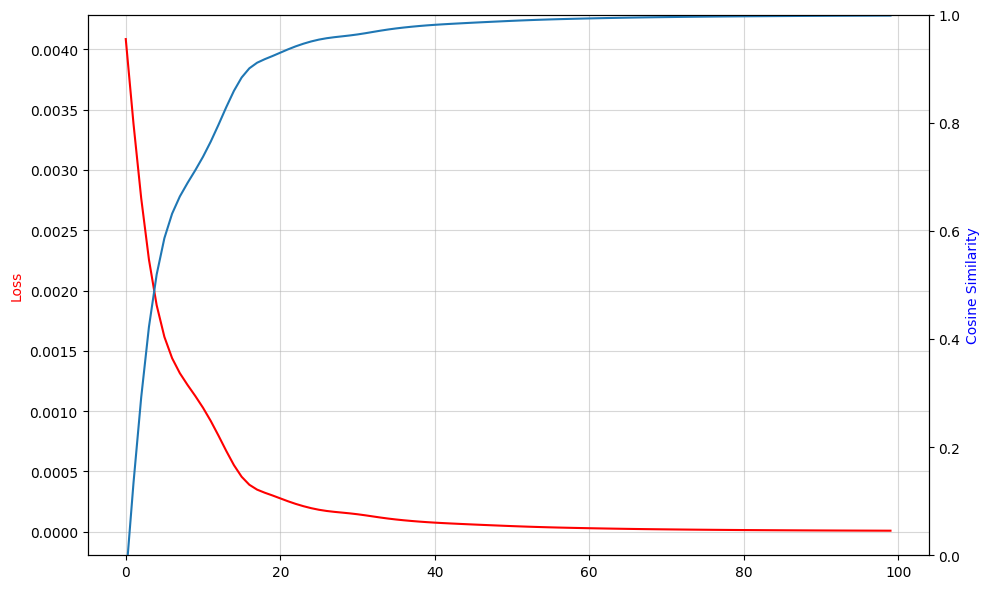

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(losses, color="red")
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.5)
ax1.set_ylabel('Loss', color="red")

ax2 = ax1.twinx()
ax2.plot(cos_sims)
ax2.tick_params(axis='y')
ax2.set_ylabel('Cosine Similarity', color="blue")
ax2.set_ylim(0, 1)

fig.tight_layout()
plt.show()

In [ ]:
decoder.eval()
with torch.no_grad():
    pred_txt_test = decoder(features_img_test)

In [ ]:
with torch.no_grad():
    cos_sim_matrix = pred_txt_test @ features_txt_test.T #(NxN)
    diag_sim = torch.diag(cos_sim_matrix).mean().item()

print(f"Diag CosSim: {diag_sim:.4f}")

Diag CosSim: 0.9908


In [ ]:
img_embs = features_img_test.cpu().numpy()          # (N_img x D)
txt_embs = features_txt_test.cpu().numpy()
decoder.eval()
with torch.no_grad():
    pred_embs = decoder(features_img_test).cpu().numpy()

all_embs = np.vstack([txt_embs, img_embs, pred_embs])
all_2d = tsne.fit_transform(all_embs)

# Разделяем обратно
n = len(txt_embs)
txt_2d = all_2d[:n] 
img_2d = all_2d[n:2*n]
pred_2d = all_2d[2*n:]

In [ ]:
print(len(txt_2d))
print(len(img_2d))
print(len(pred_2d))

250
250
250


C:\Users\root\AppData\Local\Temp\ipykernel_9988\2873769537.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


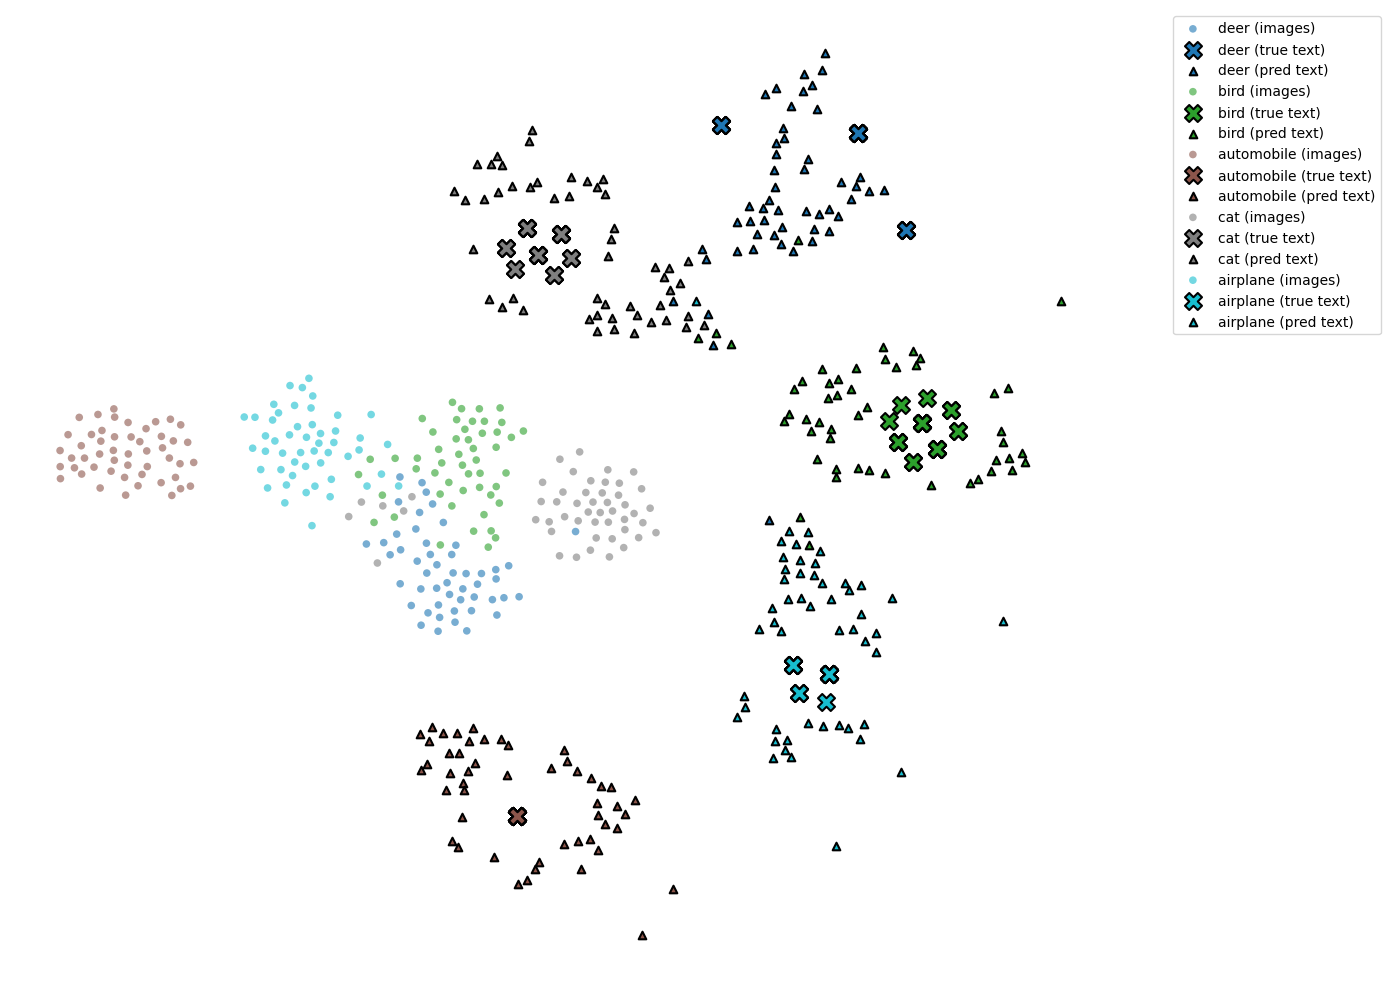

In [ ]:
labels_np = np.array(labels_test)
unique_classes = list(set(labels_test))
colors = plt.cm.get_cmap('tab10', len(unique_classes))

plt.figure(figsize=(14, 10))

for i, cls in enumerate(unique_classes):
    mask = (labels_np == cls)
    
    # img
    plt.scatter(
        img_2d[mask, 0],
        img_2d[mask, 1],
        c=[colors(i)],
        label=f'{cls} (images)',
        alpha=0.6,
        s=30,
        edgecolor='none'
    )
    
    # txt
    plt.scatter(
        txt_2d[mask, 0],
        txt_2d[mask, 1],
        c=[colors(i)],
        marker='X',
        s=150,
        edgecolors='k',
        linewidth=1.5,
        label=f'{cls} (true text)'
    )
    
    # pred txt
    plt.scatter(
        pred_2d[mask, 0],
        pred_2d[mask, 1],
        c=[colors(i)],
        marker='^',
        s=30,
        edgecolors='k',
        linewidth=1.5,
        label=f'{cls} (pred text)'
    )


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
with torch.no_grad():
    cos_sim_pred_true = (pred_txt_test * features_txt_test).sum(dim=-1).mean().item()
    cos_sim_pred_img = (pred_txt_test * features_img_test).sum(dim=-1).mean().item()

print(f"CosSim (pred txt - test txt): {cos_sim_pred_true}")
print(f"CosSim (pred txt - test img): {cos_sim_pred_img}")

CosSim (pred txt - test txt): 0.990800678730011
CosSim (pred txt - test img): 0.26175037026405334


In [ ]:
for i, cls in enumerate(CLASSES):
    txt = pred_txt_test[i]
    imgs = features_img_test[np.array(labels_test) == cls]
    sims = imgs @ txt
    print(cls, sims.mean())

cat tensor(0.2611)
deer tensor(0.2116)
airplane tensor(0.2232)
automobile tensor(0.1858)
bird tensor(0.2093)


In [ ]:
ship_img_test, ship_txt_test, ship_labels_test = get_embeddings(IMAGE_TEST, ["ship"])

decoder.eval()
with torch.no_grad():
    pred_ship = decoder(ship_img_test)

In [ ]:
for i, cls in enumerate(['ship']):
    txt = pred_ship[i]
    imgs = ship_img_test[np.array(ship_labels_test) == cls]
    sims = imgs @ txt
    print(cls, sims.mean())

cos_sim_pred_true = (ship_txt_test * pred_ship).sum(dim=-1).mean().item()
print(cos_sim_pred_true)

ship tensor(0.2029)
0.9072832465171814


In [ ]:
all_img = np.vstack([features_img_test.cpu().numpy(), ship_img_test.cpu().numpy()])
all_txt = np.vstack([features_txt_test.cpu().numpy(), ship_txt_test.cpu().numpy()])
all_pred = np.vstack([decoder(features_img_test).detach().numpy(), pred_ship.cpu().numpy()])

all_embs = np.vstack([all_txt, all_img, all_pred])
all_2d = tsne.fit_transform(all_embs)

N_orig = len(features_img_test)
N_ship = len(ship_img_test)
N_total = N_orig + N_ship

txt_2d = all_2d[:N_total]
img_2d = all_2d[N_total:2*N_total]
pred_2d = all_2d[2*N_total:]

In [ ]:
labels_all = labels_test + ship_labels_test
labels_np = np.array(labels_all)

C:\Users\root\AppData\Local\Temp\ipykernel_9988\3821201017.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_old))


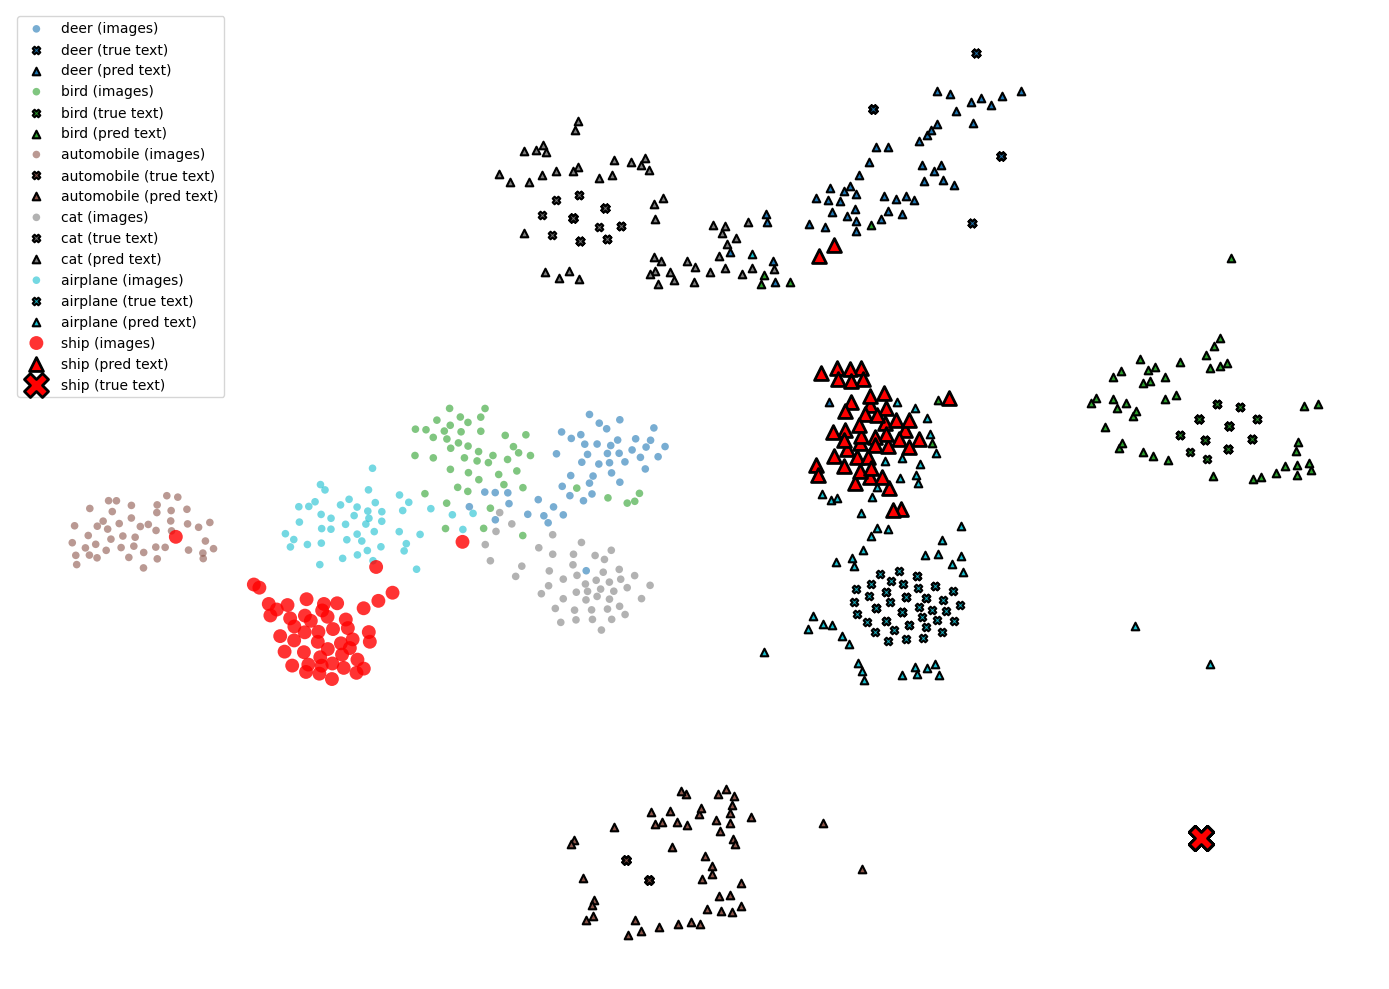

In [ ]:
plt.figure(figsize=(14, 10))

unique_old = list(set(labels_test))
colors = plt.cm.get_cmap('tab10', len(unique_old))

for i, cls in enumerate(unique_old):
    mask = (labels_np == cls)
    plt.scatter(img_2d[mask, 0], img_2d[mask, 1], c=[colors(i)], alpha=0.6, s=30, edgecolor='none', label=f'{cls} (images)')
    plt.scatter(txt_2d[mask, 0], txt_2d[mask, 1], c=[colors(i)], marker='X', s=30, edgecolors='k', linewidth=1.5, label=f'{cls} (true text)')
    plt.scatter(pred_2d[mask, 0], pred_2d[mask, 1], c=[colors(i)], marker='^', s=30, edgecolors='k', linewidth=1.5, label=f'{cls} (pred text)')

mask_ship = (labels_np == "ship")
plt.scatter(img_2d[mask_ship, 0], img_2d[mask_ship, 1], c='red', alpha=0.8, s=100, label='ship (images)', edgecolor='none')
plt.scatter(pred_2d[mask_ship, 0], pred_2d[mask_ship, 1], c='red', marker='^', s=100, edgecolors='k', linewidth=2, label='ship (pred text)')
plt.scatter(txt_2d[mask_ship, 0], txt_2d[mask_ship, 1], c='red', marker='X', s=300, edgecolors='k', linewidth=2, label='ship (true text)')

plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()